# **Desafio Ifood - Parte 2**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("dark")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
df_ifood = pd.read_csv("./mkt_data.csv")
df_ifood.head()

,Unnamed: 0,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,marital_status,education_level,kids,expenses
0,0,58138.0,0,0,58,635,88,546,172,88,...,3.0,NaN,NaN,1529,1441,0,Single,Graduation,0,1529
1,1,46344.0,1,1,38,11,1,6,2,1,...,3.0,NaN,NaN,21,15,0,Single,Graduation,2,21
2,2,71613.0,0,0,26,426,49,127,111,21,...,3.0,NaN,NaN,734,692,0,Together,Graduation,0,734
3,3,26646.0,1,0,26,11,4,20,10,3,...,3.0,NaN,NaN,48,43,0,Together,Graduation,1,48
4,4,58293.0,1,0,94,173,43,118,46,27,...,NaN,NaN,5.0,407,392,0,Married,PhD,1,407


In [3]:
df_ifood["kids_1"] = df_ifood.kids.apply(lambda x: 0 if x == 0 else 1)
df_ifood.kids_1

0       0
1       1
2       0
3       1
4       1
       ..
2200    1
2201    1
2202    0
2203    1
2204    1
Name: kids_1, Length: 2205, dtype: int64

In [4]:
df_ifood.kids_1.value_counts()

kids_1
1    1577
0     628
Name: count, dtype: int64

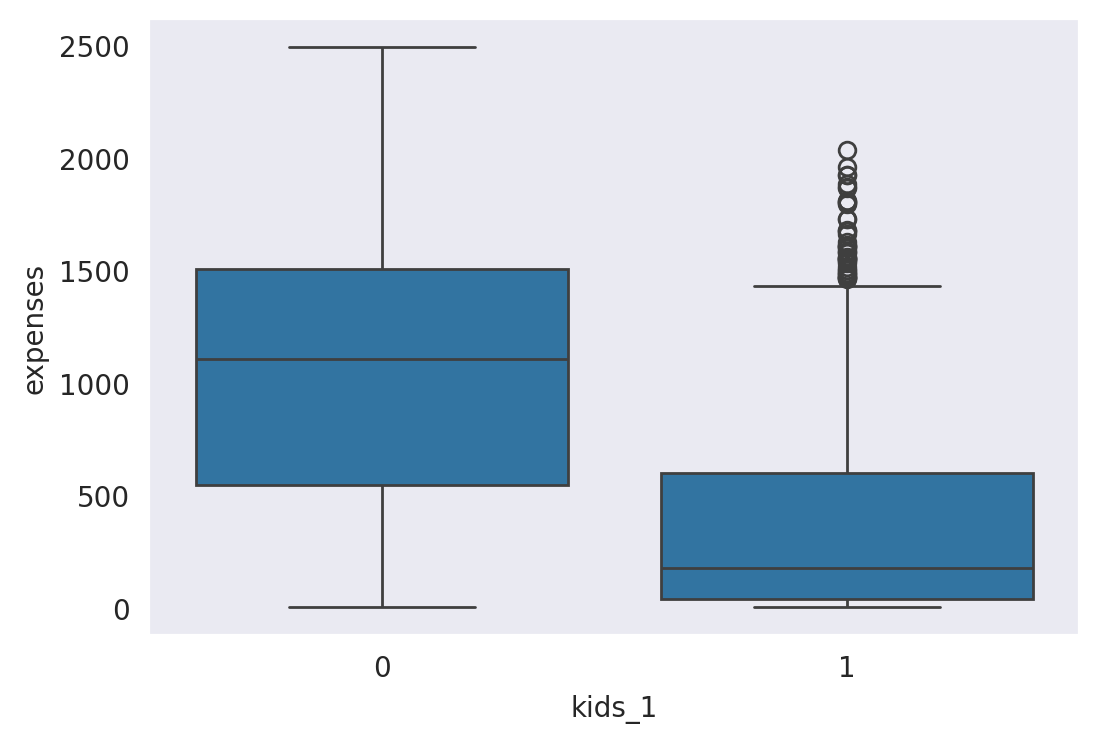

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_ifood, x="kids_1", y="expenses")
plt.show()

#### Obtendo a variância da coluna `expenses`

In [6]:
df_ifood.groupby("kids_1").expenses.var()

kids_1
0    391544.158037
1    180568.557933
Name: expenses, dtype: float64

### ***Aplicando o teste de Hipôtese***

Para usar o teste `t` comparando a média de `espenses (despesas)` para famílias com ou sem crianças precisamos antes de mais nada descobrir se as variâncias são igauis ou diferentes, pois temos testes `t` diferentes para cada caso.


Para esse tipo de dado, vamos usar o teste `F` para verificar se as variâncias são iguais ou diferentes, para isso é necessário realizar o pré-processamento dos dados, separando em duas séries pandas. Após esse processo, iremos usar o módulo  `scipy.stats` que implementa o teste `F`.

In [7]:
from scipy import stats

# Série com o gasto de família com crianças
espenses_com_criancas = df_ifood[df_ifood.kids_1 == 1].expenses

# Série com o gasto de família sem crianças
espenses_sem_criancas = df_ifood[df_ifood.kids_1 == 0].expenses

grau_liberdade_cc = espenses_com_criancas.size - 1  # Grau de liberdade da primeira amostra
grau_liberdade_sc = espenses_sem_criancas.size - 1  # Grau de liberdade da segunda amostra

F = espenses_sem_criancas.var() / espenses_com_criancas.var() # obs: A maior variância tem que ir no numerador!

alpha = 0.05

# p-valor para o teste F
1 - stats.f.cdf(F, grau_liberdade_sc, grau_liberdade_cc)


1.1102230246251565e-16

Como o p-valor é muito menor que a significância adotada de `0.05`, dizemos que as variâncias são diferentes.

#### ***Aplicando o teste `t`***

Por não possuirmos o desvio-padrão populacional das amostras, mas possuirmos a média e desvio-padrão amostral e temos amostras com mais de 20 dados, podemos usar o teste t para amostras independentes para avaliarmos se as médias são significativamente diferentes.

In [8]:
stats.ttest_ind(espenses_com_criancas, espenses_sem_criancas)

Ttest_indResult(statistic=-28.902593571564687, pvalue=5.171525024868465e-156)

> *O p-valor é muito menor que alpha(0,05). Logo, **rejeitamos** a hipótese nula. Ou seja, há evidências suficiente, ao nível de significância de 5%, para a afirmação de que as médias de despesas (espenses) são estatísticamente diferentes.*

In [9]:
# obtendo as médias para cada grupo de famílio com e sem filhos
print(f"\nMédia expenses com filhos: {espenses_com_criancas.mean():.2f}")
print(f"Média expenses sem filhos: {espenses_sem_criancas.mean():.2f}\n")


Média expenses com filhos: 372.24
Média expenses sem filhos: 1041.21



> ***Portanto, podemos observar que a média de despesas de família sem filhos é maior comparado com família com filhos***

### **Comparando os grupos de pessoas com filhos**

O time de marketing nos pediu para verificar se há diferenças de gastos (expenses) em quem tem 1, 2, 3 ou mais filhos para que eles possam afunilar mais ainda a campanha. A média desses grupos é diferente? Qual(is) tem menor média?

In [10]:
subgrupo_cf = df_ifood[df_ifood.kids != 0]
subgrupo_cf.groupby("kids").expenses.mean()

kids
1    434.530576
2    221.568675
3    237.380000
Name: expenses, dtype: float64

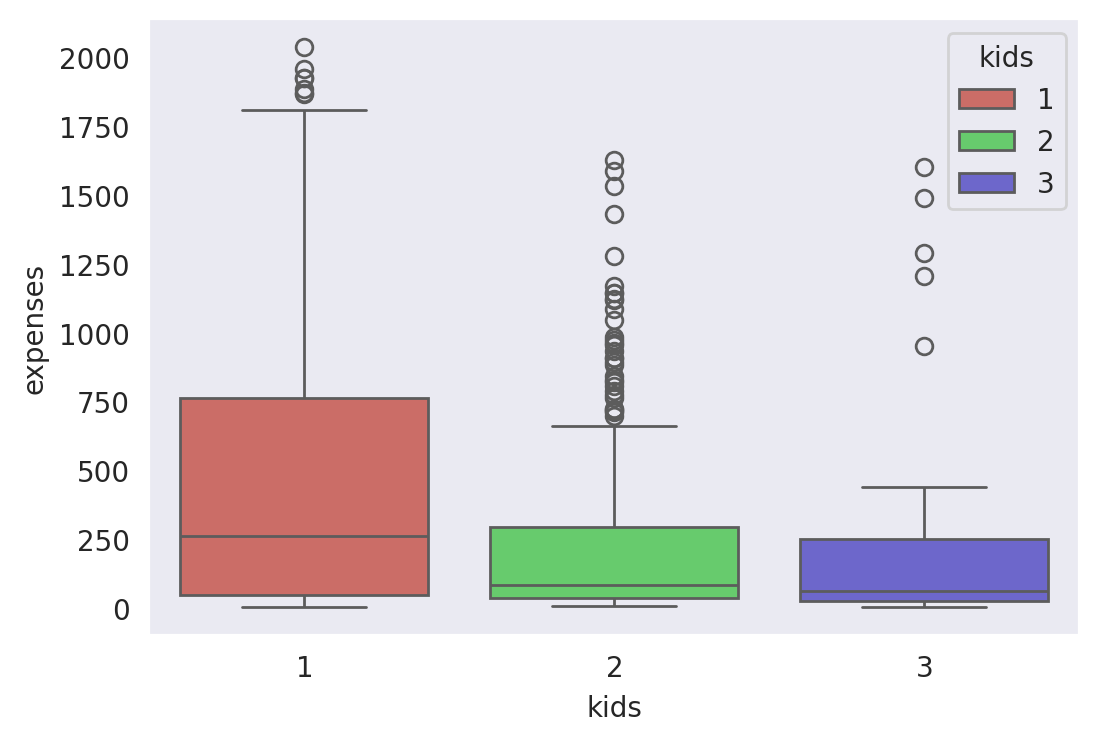

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=subgrupo_cf, x="kids", y="expenses",
            hue="kids",
            palette=sns.color_palette("hls", 3))

plt.show()

As premissas para usarmos `ANOVA 1 fator` são:

* Amostras aleatórias ***(OK)***
* Grupos independentes ***(OK)***
* A variável dependente é contínua ***(OK)***
* Amostras tem pelo menos n = 15 cada ***(OK)***
* Variancias populacionais em cada grupo é igual  ***(Verificar)***

H0: Todas as médias do grupo são iguais.

Ha: Nem todas as médias do grupo são iguais.

In [12]:
expenses_com_1f = df_ifood[df_ifood.kids == 1].expenses.dropna()
expenses_com_2f = df_ifood[df_ifood.kids == 2].expenses.dropna()
expenses_com_3f = df_ifood[df_ifood.kids == 3].expenses.dropna()

In [13]:
import scipy.stats as stats

stats.bartlett(expenses_com_1f, expenses_com_2f, expenses_com_3f)

BartlettResult(statistic=102.21719770243517, pvalue=6.365280420300725e-23)

Temos que o p-valor é menor que alpha (0,05), dessa forma, conclui-se que as amostras não possuiem a mesma variância, Portanto, não podemos usar a `ANOVA 1 fator`, no entanto, pode-se usar uma mariante chamada ANOVA de Welch.

In [14]:
import pingouin as pg

df_com_filhos = df_ifood[df_ifood.kids != 0]

pg.welch_anova(dv="expenses", between="kids", data=df_com_filhos)

,Source,ddof1,ddof2,F,p-unc,np2
0,kids,2,132.724442,59.721904,3.178541e-19,0.051464


Analisando o resultado temos que o p-valor é menor do que alpha (0.05), portanto, rejeitamos H0 e concluimos que a 95% de confiança, todas as médias não são iguais.

Agora, vamos usar um teste post hoc para descobrir qual dos pares não são iguais. Lembrando que esses dados violam a aproximação de dados para normalidade e as amostras não tem variancias iguais. Não podemos usar Tukey nesse caso.

In [15]:
pg.pairwise_gameshowell(dv="expenses", between="kids", data=df_com_filhos)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1,2,434.530576,221.568675,212.961901,19.678256,10.822194,1152.588538,2.596812e-13,0.513077
1,1,3,434.530576,237.380000,197.150576,56.823741,3.469511,55.099957,2.888048e-03,0.437688
2,2,3,221.568675,237.380000,-15.811325,56.988869,-0.277446,55.722906,9.584865e-01,-0.052201


Apenas quando p-valor for maior do que 5e-02 aceitamos H0 (médias iguais). Logo, todas as médias são consideradas diferentes, exceto a 2-3.

Portanto, caso a equipe queira se focar na amostra com menor média, eles poderão focar tanto no grupo 2 quanto no 3.

Um adendo importante que também devemos levar para o time de marketing é o volume de pessoas do grupo com 2 ou 3 filhos no campo de abrangência da campanha (Brasil, por exemplo). A quantidade de pessoas que tem 2 ou 3 filhos deve ser levada em conta também para entender nosso share em cada um desses mercados e entender qual deles teríamos maior gap

Portanto, rejeitamos a hipótese nula para as diferenças 1-2 e 1-3. Ou seja, há diferenças estatísticas entre esses grupos, o que nesse caso nos mostra que o 1 é diferente de 2 e 3 (olhando a média, de fato é bastante maior) e a amostra 2 e 3 são estatisticamente iguais.

Portanto, caso a equipe queira se focar na amostra com menor média, eles poderão focar tanto no grupo 2 quanto no 3.

Um adendo importante que também devemos levar para o time de marketing é o volume de pessoas do grupo com 2 ou 3 filhos no campo de abrangência da campanha (Brasil, por exemplo). A quantidade de pessoas que tem 2 ou 3 filhos deve ser levada em conta também para entender nosso share em cada um desses mercados e entender qual deles teríamos maior gap